In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.similarity_function = nn.CosineSimilarity(dim=2)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
    
    def _get_correlated_mask(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size

        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_function(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)
        positives = torch.cat((sim_i_j, sim_j_i), dim=0)
        
        mask = self._get_correlated_mask(batch_size).to(z.device)
        negatives = sim[mask].view(N, -1)

        labels = torch.zeros(N).to(z_i.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)

        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [3]:
data_pth = r'C:\Users\VSIE43\OneDrive - Scania CV\Thesis\SKAB-master\data/'
normal_file = 'anomaly-free/anomaly-free.csv'
test_1 = 'other'
test_2 = 'valve1'
test_3 = 'valve2'

df = pd.read_csv(data_pth + normal_file, sep=';')

def fillin_time_gaps(df):
    df.datetime = pd.to_datetime(df.datetime.values)
    time_diff = np.diff(df.datetime.values)

    new_time = pd.date_range(df.datetime.min(), df.datetime.max(), freq='1s')
    missing_time = pd.DataFrame({'datetime': new_time})
    df_new = missing_time.merge(df, on='datetime', how='left')

    df_new = df_new.interpolate(method='ffill')
    return df_new

normal_data = []
df = pd.read_csv(data_pth + normal_file, sep=';')
normal_data.append(fillin_time_gaps(df).drop(columns=['datetime']))
for folder in [test_2, test_3]:
    files = os.listdir(data_pth + folder)
    for file in files:
        tmp = pd.read_csv(data_pth + folder + '/' + file, sep=';')
        t = tmp[tmp.anomaly == 0]
        t = t.drop(columns=['changepoint'])
        normal_data.append(t)

df = fillin_time_gaps(df)

def min_max_normalize(df, m_m_params=None):
    if m_m_params:
        (min_p, max_p) = m_m_params
    else:
        (min_p, max_p) = df.min(), df.max()

    new_df = (df - min_p) / (max_p - min_p)
    return new_df, (min_p, max_p)

data, m_m_params = min_max_normalize(df.drop(columns=['datetime']))

test_df_1 = pd.read_csv(data_pth + test_1 + '/1.csv', sep=';')
test_df_1_norm, _ = min_max_normalize(test_df_1.drop(columns=['datetime', 'anomaly', 'changepoint']), m_m_params)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def create_temporal_features(df):
    features = []
    for t in range(len(df)):
        x_t = torch.tensor(df.iloc[t].values, dtype=torch.float).view(-1, 1)
        features.append(x_t)
    return features

temporal_features_train = create_temporal_features(data)
temporal_features_test = create_temporal_features(test_df_1_norm)

def create_sliding_windows(features, window_size, stride):
    windows = []
    next_step_t = []

    for i in range(0, len(features) - window_size, stride):
        window = features[i:i + window_size]
        next_step_window = features[i + 1:i + window_size + 1]
        
        if len(next_step_window) == window_size:  # Ensure that the next step window has the same length as the window
            windows.append(window)
            next_step_t.append(next_step_window)

    return np.array(windows), np.array(next_step_t)

window_size = 16
stride = 1

temporal_windows_train, temporal_windows_train_next_step = create_sliding_windows(temporal_features_train, window_size, stride)
temporal_windows_test, temporal_windows_test_next_step = create_sliding_windows(temporal_features_test, window_size, stride)

print(f"temporal_windows_train shape: {temporal_windows_train.shape}")
print(f"temporal_windows_train_next_step shape: {temporal_windows_train_next_step.shape}")
print(f"temporal_windows_test shape: {temporal_windows_test.shape}")
print(f"temporal_windows_test_next_step shape: {temporal_windows_test_next_step.shape}")

# Ensure lengths match
assert len(temporal_windows_train) == len(temporal_windows_train_next_step), "Mismatch in training windows and next steps"
assert len(temporal_windows_test) == len(temporal_windows_test_next_step), "Mismatch in testing windows and next steps"

class TimeSeriesDataset(Dataset):
    def __init__(self, windows, next_step_t):
        self.windows = windows
        self.next_step_t = next_step_t

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        next_step_window = self.next_step_t[idx]
        return window, next_step_window

# Create dataset objects
train_dataset = TimeSeriesDataset(temporal_windows_train, temporal_windows_train_next_step)
test_dataset = TimeSeriesDataset(temporal_windows_test, temporal_windows_test_next_step)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\VSIE43\AppData\Local\Temp\ipykernel_37980\3272466593.py:17: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new = df_new.interpolate(method='ffill')
C:\Users\VSIE43\AppData\Local\Temp\ipykernel_37980\3272466593.py:17: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new = df_new.interpolate(method='ffill')


temporal_windows_train shape: (9945, 16, 8, 1)
temporal_windows_train_next_step shape: (9945, 16, 8, 1)
temporal_windows_test shape: (729, 16, 8, 1)
temporal_windows_test_next_step shape: (729, 16, 8, 1)


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=5000, dropout=0.3):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.encoding = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-np.log(10000.0) / hidden_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        x = x + self.encoding[:x.size(0), :]
        return self.dropout(x)

class AttentionAdjacencyLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, max_len=5000):
        super(AttentionAdjacencyLayer, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.multihead_attn1 = nn.MultiheadAttention(hidden_dim, num_heads)
        self.multihead_attn2 = nn.MultiheadAttention(hidden_dim, num_heads)
        self.multihead_attn3 = nn.MultiheadAttention(hidden_dim, num_heads)
        # self.multihead_attn4 = nn.MultiheadAttention(hidden_dim, num_heads)

        self.fc3 = nn.Linear(3 * hidden_dim, 2 * hidden_dim)  
        self.fc4 = nn.Linear(2 * hidden_dim, hidden_dim)  
        self.fc5 = nn.Linear(hidden_dim, input_dim)

        self.positional_encoding = PositionalEncoding(hidden_dim, max_len)
        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        N, W, F = x.shape
        
        x = self.leakyrelu(self.fc1(x))  
        x = self.leakyrelu(self.fc2(x))  
        
        x = x.permute(1, 0, 2)  
        x = self.positional_encoding(x)

        attn_output1, _ = self.multihead_attn1(x, x, x)  
        attn_output2, _ = self.multihead_attn2(x, x, x)
        attn_output3, _ = self.multihead_attn3(x, x, x)
        # attn_output4, _ = self.multihead_attn4(x, x, x)

        attn_output = torch.cat((attn_output1, attn_output2, attn_output3), dim=-1)  
        attn_output = attn_output.permute(1, 0, 2)  
        
        x = self.leakyrelu(self.fc3(attn_output))  
        x = self.leakyrelu(self.fc4(x))  
        x = self.fc5(x)  

        adj_matrix = torch.bmm(x.permute(0, 2, 1), x)  
        adj_matrix = self.sigmoid(adj_matrix)
        
        return adj_matrix

class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        return self.conv(x, edge_index, edge_weight)

class GNNAnomalyDetection(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, dropout=0.5):
        super(GNNAnomalyDetection, self).__init__()
        self.adj_layer = AttentionAdjacencyLayer(input_dim, hidden_dim, num_heads)
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim)
        self.gcn3 = GCNLayer(hidden_dim, output_dim)
        self.lstm = nn.LSTM(output_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        N, W, F = x.shape
        
        adj_matrix = self.adj_layer(x)
        edge_index, edge_weight = self.adj_to_edge_index(adj_matrix)

        gcn_outputs = []
        for t in range(W):
            gcn_output = self.gcn1(x[:, t, :].view(-1, F), edge_index)
            gcn_output = self.relu(gcn_output)
            gcn_output = self.gcn2(gcn_output, edge_index)
            gcn_output = self.relu(gcn_output)
            gcn_output = self.gcn3(gcn_output, edge_index)
            gcn_output = self.relu(gcn_output)
            gcn_output = gcn_output.view(N, -1, self.gcn3.conv.out_channels)
            gcn_outputs.append(gcn_output)

        gcn_outputs = torch.stack(gcn_outputs, dim=1)  # Shape: [batch_size, sequence_length, num_nodes, hidden_channels*2]
        gcn_outputs = gcn_outputs.view(N, W, -1)  # Flatten the node dimension for LSTM

        lstm_out, _ = self.lstm(gcn_outputs)
        lstm_out = self.dropout(lstm_out)
        x = self.fc(lstm_out)
        x = self.sigmoid(x)
        return x, adj_matrix

    def adj_to_edge_index(self, adj_matrix):
        N, F, _ = adj_matrix.shape
        edge_index_list = []
        edge_weight_list = []
        for n in range(N):
            edge_index = torch.nonzero(adj_matrix[n], as_tuple=False).t().contiguous()
            edge_weight = adj_matrix[n][edge_index[0], edge_index[1]]
            edge_index_list.append(edge_index)
            edge_weight_list.append(edge_weight)
        edge_index = torch.cat(edge_index_list, dim=1)
        edge_weight = torch.cat(edge_weight_list)
        return edge_index, edge_weight

In [27]:
input_dim = temporal_windows_train.shape[-2]
hidden_dim = 32
output_dim = temporal_windows_train.shape[-2]
learning_rate = 0.00001
num_epochs = 50
sparsity_weight = 0.5

# Model, Loss, and Optimizer
model = GNNAnomalyDetection(input_dim, hidden_dim, output_dim, num_heads=8)
criterion = NTXentLoss(temperature=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

GNNAnomalyDetection(
  (adj_layer): AttentionAdjacencyLayer(
    (fc1): Linear(in_features=8, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (multihead_attn1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (multihead_attn2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (multihead_attn3): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (fc3): Linear(in_features=96, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=8, bias=True)
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (sigmoid): Sigmoid()
  )
  (gcn1): GCNLayer(
    (

In [34]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, projection_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, projection_dim)
        self.fc2 = nn.Linear(projection_dim, projection_dim)
        self.relu = nn.ReLU()

    def forward(self, h):
        z = self.relu(self.fc1(h))
        z = self.fc2(z)
        return z

input_dim = 8  # Replace with your actual input dimension for the projection head
projection_dim = 32  # Dimension of the contrastive learning space
projection_head = ProjectionHead(input_dim, projection_dim)

In [41]:
def train_contrastive_model_with_projection(train_loader, model, projection_head, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        projection_head.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for windows, next_step_window in train_loader:
                optimizer.zero_grad()
                windows = windows.squeeze(-1).type(torch.float32)
                next_step_window = next_step_window.squeeze(-1).type(torch.float32)

                # Get representations h_i and h_j from the original GNN model
                h_i, _ = model(windows)
                h_j = next_step_window
                # print(h_i.shape)

                # Project h_i and h_j to z_i and z_j using the projection head
                z_i = projection_head(h_i)
                z_j = projection_head(h_j)

                # Flatten z_i and z_j for the contrastive loss
                z_i = z_i.view(z_i.size(0), -1)
                z_j = z_j.view(z_j.size(0), -1)

                # Compute contrastive loss
                loss = criterion(z_i, z_j)

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

# Assuming optimizer is defined
train_contrastive_model_with_projection(train_loader, model, projection_head, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50: 100%|██████████| 311/311 [00:17<00:00, 17.92it/s]


Epoch [1/50], Loss: 4.1462


Epoch 2/50: 100%|██████████| 311/311 [00:17<00:00, 17.67it/s]


Epoch [2/50], Loss: 4.1462


Epoch 3/50: 100%|██████████| 311/311 [00:17<00:00, 17.88it/s]


Epoch [3/50], Loss: 4.1461


Epoch 4/50: 100%|██████████| 311/311 [00:17<00:00, 17.54it/s]


Epoch [4/50], Loss: 4.1461


Epoch 5/50: 100%|██████████| 311/311 [00:18<00:00, 16.80it/s]


Epoch [5/50], Loss: 4.1460


Epoch 6/50: 100%|██████████| 311/311 [00:17<00:00, 17.62it/s]


Epoch [6/50], Loss: 4.1459


Epoch 7/50: 100%|██████████| 311/311 [00:17<00:00, 17.67it/s]


Epoch [7/50], Loss: 4.1459


Epoch 8/50: 100%|██████████| 311/311 [00:18<00:00, 17.00it/s]


Epoch [8/50], Loss: 4.1458


Epoch 9/50: 100%|██████████| 311/311 [00:17<00:00, 17.43it/s]


Epoch [9/50], Loss: 4.1458


Epoch 10/50: 100%|██████████| 311/311 [00:17<00:00, 17.59it/s]


Epoch [10/50], Loss: 4.1457


Epoch 11/50: 100%|██████████| 311/311 [00:18<00:00, 17.19it/s]


Epoch [11/50], Loss: 4.1456


Epoch 12/50: 100%|██████████| 311/311 [00:17<00:00, 17.53it/s]


Epoch [12/50], Loss: 4.1456


Epoch 13/50: 100%|██████████| 311/311 [00:17<00:00, 17.35it/s]


Epoch [13/50], Loss: 4.1455


Epoch 14/50: 100%|██████████| 311/311 [00:17<00:00, 17.36it/s]


Epoch [14/50], Loss: 4.1455


Epoch 15/50: 100%|██████████| 311/311 [00:18<00:00, 17.13it/s]


Epoch [15/50], Loss: 4.1454


Epoch 16/50: 100%|██████████| 311/311 [00:17<00:00, 17.70it/s]


Epoch [16/50], Loss: 4.1454


Epoch 17/50: 100%|██████████| 311/311 [00:17<00:00, 17.41it/s]


Epoch [17/50], Loss: 4.1454


Epoch 18/50: 100%|██████████| 311/311 [00:17<00:00, 17.54it/s]


Epoch [18/50], Loss: 4.1453


Epoch 19/50: 100%|██████████| 311/311 [00:17<00:00, 17.40it/s]


Epoch [19/50], Loss: 4.1453


Epoch 20/50: 100%|██████████| 311/311 [00:17<00:00, 17.28it/s]


Epoch [20/50], Loss: 4.1452


Epoch 21/50: 100%|██████████| 311/311 [00:17<00:00, 17.48it/s]


Epoch [21/50], Loss: 4.1452


Epoch 22/50: 100%|██████████| 311/311 [00:18<00:00, 17.14it/s]


Epoch [22/50], Loss: 4.1451


Epoch 23/50: 100%|██████████| 311/311 [00:17<00:00, 17.63it/s]


Epoch [23/50], Loss: 4.1451


Epoch 24/50: 100%|██████████| 311/311 [00:17<00:00, 17.35it/s]


Epoch [24/50], Loss: 4.1450


Epoch 25/50: 100%|██████████| 311/311 [00:17<00:00, 17.57it/s]


Epoch [25/50], Loss: 4.1450


Epoch 26/50: 100%|██████████| 311/311 [00:17<00:00, 17.37it/s]


Epoch [26/50], Loss: 4.1450


Epoch 27/50: 100%|██████████| 311/311 [00:17<00:00, 17.50it/s]


Epoch [27/50], Loss: 4.1449


Epoch 28/50: 100%|██████████| 311/311 [00:17<00:00, 17.39it/s]


Epoch [28/50], Loss: 4.1449


Epoch 29/50: 100%|██████████| 311/311 [00:17<00:00, 17.66it/s]


Epoch [29/50], Loss: 4.1448


Epoch 30/50: 100%|██████████| 311/311 [00:17<00:00, 17.30it/s]


Epoch [30/50], Loss: 4.1448


Epoch 31/50: 100%|██████████| 311/311 [00:17<00:00, 17.45it/s]


Epoch [31/50], Loss: 4.1447


Epoch 32/50: 100%|██████████| 311/311 [00:18<00:00, 17.14it/s]


Epoch [32/50], Loss: 4.1447


Epoch 33/50: 100%|██████████| 311/311 [00:17<00:00, 17.30it/s]


Epoch [33/50], Loss: 4.1447


Epoch 34/50: 100%|██████████| 311/311 [00:17<00:00, 17.62it/s]


Epoch [34/50], Loss: 4.1447


Epoch 35/50: 100%|██████████| 311/311 [00:17<00:00, 17.30it/s]


Epoch [35/50], Loss: 4.1446


Epoch 36/50: 100%|██████████| 311/311 [00:17<00:00, 17.71it/s]


Epoch [36/50], Loss: 4.1446


Epoch 37/50: 100%|██████████| 311/311 [00:17<00:00, 17.51it/s]


Epoch [37/50], Loss: 4.1445


Epoch 38/50: 100%|██████████| 311/311 [00:17<00:00, 17.69it/s]


Epoch [38/50], Loss: 4.1445


Epoch 39/50: 100%|██████████| 311/311 [00:18<00:00, 17.20it/s]


Epoch [39/50], Loss: 4.1444


Epoch 40/50: 100%|██████████| 311/311 [00:17<00:00, 17.43it/s]


Epoch [40/50], Loss: 4.1444


Epoch 41/50: 100%|██████████| 311/311 [00:17<00:00, 17.28it/s]


Epoch [41/50], Loss: 4.1444


Epoch 42/50: 100%|██████████| 311/311 [00:17<00:00, 17.71it/s]


Epoch [42/50], Loss: 4.1444


Epoch 43/50: 100%|██████████| 311/311 [00:17<00:00, 17.44it/s]


Epoch [43/50], Loss: 4.1444


Epoch 44/50: 100%|██████████| 311/311 [00:17<00:00, 17.35it/s]


Epoch [44/50], Loss: 4.1443


Epoch 45/50: 100%|██████████| 311/311 [00:17<00:00, 17.64it/s]


Epoch [45/50], Loss: 4.1444


Epoch 46/50: 100%|██████████| 311/311 [00:17<00:00, 17.34it/s]


Epoch [46/50], Loss: 4.1442


Epoch 47/50: 100%|██████████| 311/311 [00:17<00:00, 17.60it/s]


Epoch [47/50], Loss: 4.1443


Epoch 48/50: 100%|██████████| 311/311 [00:18<00:00, 17.19it/s]


Epoch [48/50], Loss: 4.1442


Epoch 49/50: 100%|██████████| 311/311 [00:17<00:00, 17.59it/s]


Epoch [49/50], Loss: 4.1442


Epoch 50/50: 100%|██████████| 311/311 [00:17<00:00, 17.41it/s]

Epoch [50/50], Loss: 4.1442


In [42]:
criterion2 = nn.MSELoss()

In [40]:
def train_model(train_loader, model, criterion, optimizer, num_epochs=20, sparsity_weight=1e-4):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for windows, next_step_window in train_loader:
                optimizer.zero_grad()
                windows = windows.squeeze(-1).type(torch.float32)
                next_step_window = next_step_window.squeeze(-1).type(torch.float32)
                outputs, adj_matrix = model(windows)
                # print('Output Shape: ', outputs.shape)
                # print('Target Windows Shape: ', next_step_window.shape)
                reconstruction_loss = criterion(outputs, next_step_window)
                sparsity_loss = torch.norm(adj_matrix, p=1)
                loss = reconstruction_loss + sparsity_weight * sparsity_loss
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

train_model(train_loader, model=model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

Epoch 1/50:  62%|██████▏   | 193/311 [00:08<00:05, 22.52it/s]


KeyboardInterrupt: 

In [43]:
def evaluate_model(test_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        reconstruction_errors = []
        preds = []
        actual = []
        adj_mats = []
        for windows, next_step_window in test_loader:
            windows = windows.squeeze(-1).type(torch.float32)
            next_step_window = next_step_window.squeeze(-1).type(torch.float32)
            outputs1, adj_mat = model(windows)
            outputs2, adj_mat = model(next_step_window)

            reconstruction_error = criterion2(outputs1.view(outputs1.size(0), -1), outputs2.view(outputs2.size(0), -1))
            reconstruction_errors.append(reconstruction_error.item())
            preds.append(outputs1)
            actual.append(next_step_window)
            adj_mats.append(adj_mat)

    return np.concatenate(adj_mats), np.concatenate(preds), np.concatenate(actual)

In [44]:
adj_mat, preds, actual = evaluate_model(test_loader, model=model, criterion=criterion)
adj_mat_train, preds_train, actual_train = evaluate_model(train_loader, model=model, criterion=criterion)

In [48]:
from sklearn.model_selection import KFold

def evaluate_model_predictions():
    dtype = torch.float32
    preds = []
    labels_tmp = []
    file_number = []
    residual_tmp_all = []
    adj_mats_all = []

    # Assuming data_pth and test_1 are defined globally
    files = os.listdir(data_pth + test_1)
    model.eval()
    print(files)
    
    for file in tqdm(files, desc="Processing files"):
        print(file)
        tmp_actual = []
        tmp_pred = []
        tmp = pd.read_csv(data_pth + test_1 + '/' + file, sep=';')

        t = tmp.anomaly.values
        test_df_1_tmp, _ = min_max_normalize(tmp.drop(columns=['datetime', 'anomaly', 'changepoint']), m_m_params)
        temporal_windows_tmp, temporal_windows_tmp_next_step = create_sliding_windows(test_df_1_tmp, window_size=16, stride=1)
        tmp_dataset = TimeSeriesDataset(temporal_windows_tmp, temporal_windows_tmp_next_step)
        tmp_loader = DataLoader(tmp_dataset, batch_size=64, shuffle=False)

        actual_values = []
        predicted_values = []
        adj_mats = []
        with torch.no_grad():
            for windows, next_step_window in tmp_loader:
                windows = windows.squeeze(-1).type(dtype)
                next_step_window = next_step_window.squeeze(-1).type(dtype)

                # Get model predictions
                outputs, adj_matrix = model(windows)
                

                actual_values.extend(next_step_window.numpy())
                predicted_values.extend(outputs.numpy())
                adj_mats.extend(adj_matrix.numpy())

        residual_tmp = np.sqrt(np.sum((np.array(predicted_values) - np.array(actual_values)) ** 2, axis=(1, 2)))
        # kf = KFold(n_splits=25)
        # thresholds = []

        # for train_index, val_index in kf.split(residual_tmp):
        #     train_losses, val_losses = residual_tmp[train_index], residual_tmp[val_index]
        #     mean_loss = np.mean(train_losses)
        #     std_loss = np.std(train_losses)
        #     thresholds.append(mean_loss + 0.7 * std_loss)

        # final_threshold = np.mean(thresholds)
        # print('Final Threshold: ', final_threshold)
        residual_tmp_all.append(residual_tmp)
        adj_mats_all.append(adj_mats)
        labels_tmp.append(t[-len(predicted_values):])
        i = int(file.split('.')[0])
        file_number.append([i] * len(predicted_values))
        preds.append(residual_tmp > 30.3)
    
    preds = np.concatenate(preds, axis=0)
    labels = np.concatenate(labels_tmp, axis=0)
    file_number = np.concatenate(file_number, axis=0)
    
    return preds, labels, file_number, residual_tmp_all, adj_mats_all

# Call the function and retrieve the results
preds, labels, file_number, residual_tmp_all, adj_mats_all = evaluate_model_predictions()

['1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']


Processing files:   0%|          | 0/14 [00:00<?, ?it/s]

1.csv


Processing files:   7%|▋         | 1/14 [00:00<00:09,  1.42it/s]

10.csv


Processing files:  14%|█▍        | 2/14 [00:01<00:09,  1.29it/s]

11.csv


Processing files:  21%|██▏       | 3/14 [00:02<00:09,  1.20it/s]

12.csv


Processing files:  29%|██▊       | 4/14 [00:03<00:07,  1.31it/s]

13.csv


Processing files:  36%|███▌      | 5/14 [00:03<00:06,  1.44it/s]

14.csv


Processing files:  43%|████▎     | 6/14 [00:04<00:05,  1.54it/s]

2.csv


Processing files:  50%|█████     | 7/14 [00:04<00:04,  1.68it/s]

3.csv


Processing files:  57%|█████▋    | 8/14 [00:05<00:03,  1.58it/s]

4.csv


Processing files:  64%|██████▍   | 9/14 [00:06<00:03,  1.49it/s]

5.csv


Processing files:  71%|███████▏  | 10/14 [00:06<00:02,  1.47it/s]

6.csv


Processing files:  79%|███████▊  | 11/14 [00:07<00:02,  1.44it/s]

7.csv


Processing files:  86%|████████▌ | 12/14 [00:08<00:01,  1.36it/s]

8.csv


Processing files:  93%|█████████▎| 13/14 [00:09<00:00,  1.36it/s]

9.csv


Processing files: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


In [49]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score

def fpr_score(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    return fp / (fp + tn)

# Metric names and corresponding functions
metric_functions = {
    'f1_score': f1_score,
    'fpr_score': fpr_score,
    'recall_score': recall_score,
    'auc_score': roc_auc_score,
}

def evaluate_metrics(labels, preds, file_number):
    for metric_name, metric_function in metric_functions.items():
        print(f"\n{metric_name}")
        for f in range(1, 15):
            true_labels = labels[file_number == f]
            pred_labels = preds[file_number == f]
            if len(true_labels) == 0 or len(pred_labels) == 0:
                continue
            print(metric_function(true_labels, pred_labels))

# Example usage
evaluate_metrics(labels, preds, file_number)


f1_score
0.8171428571428571
0.9121813031161473
0.9582806573957017
0.7872105843439913
0.9807692307692307
0.9016393442622952
0.9122257053291536
0.0
0.9292389853137516
0.0
0.0
0.831758034026465
0.07207207207207207
0.0

fpr_score
0.03512014787430684
0.0
0.019363762102351315
0.1987179487179487
0.019204389574759947
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2538940809968847
0.0

recall_score
0.7606382978723404
0.8385416666666666
0.9522613065326633
0.9037974683544304
0.9951219512195122
0.8208955223880597
0.8386167146974063
0.0
0.8678304239401496
0.0
0.0
0.7119741100323624
0.06037735849056604
0.0

auc_score
0.8627590749990167
0.9192708333333333
0.966448772215156
0.8525397598182408
0.9879587808223761
0.9104477611940298
0.9193083573487031
0.5
0.9339152119700749
0.5
0.5
0.8559870550161812
0.40324163874684066
0.5


In [ ]:
tmp_anom_list = []
for file in files:
    tmp_df = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
    tmp_anom_list.append(tmp_df.anomaly)
    plt.plot(tmp_df.anomaly)

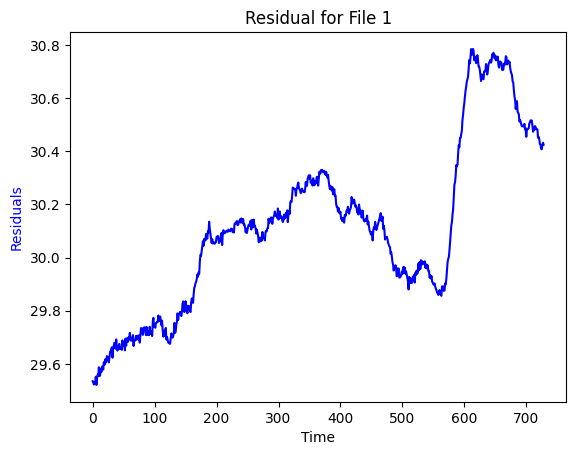

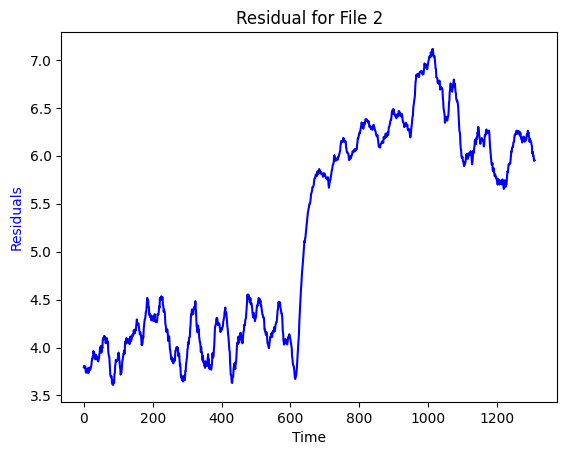

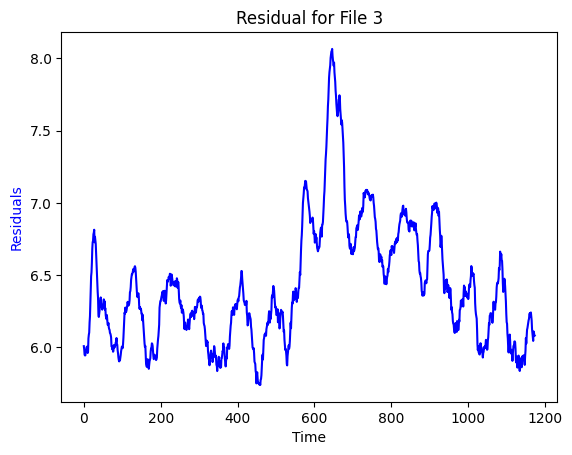

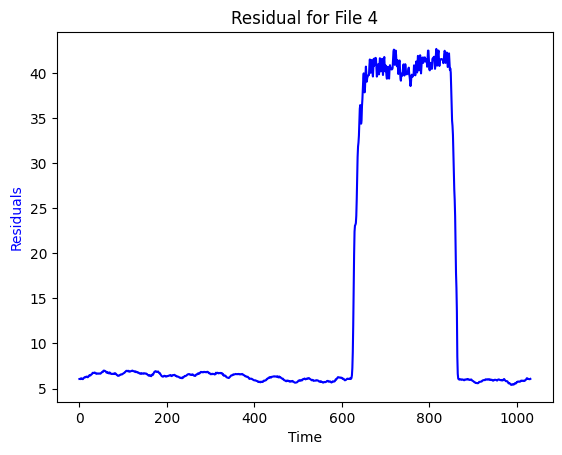

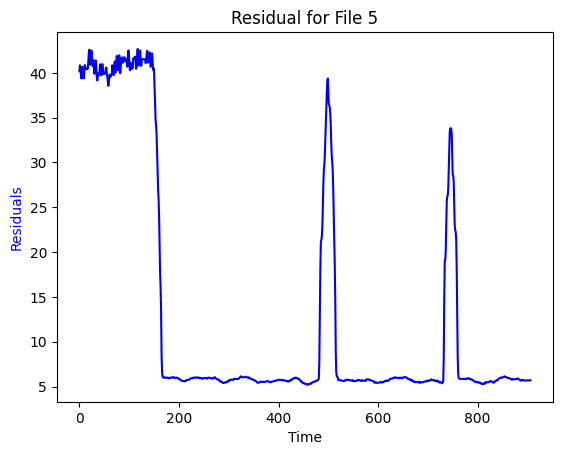

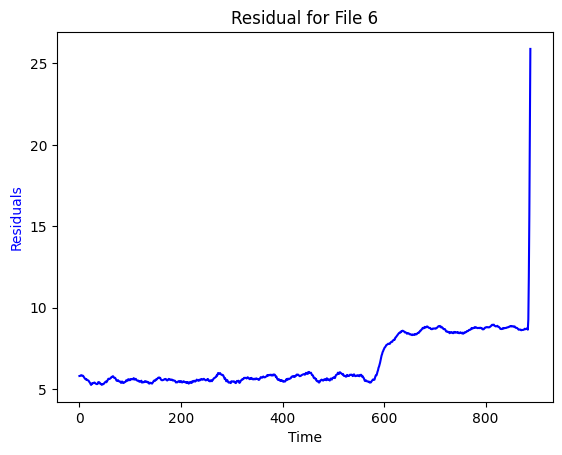

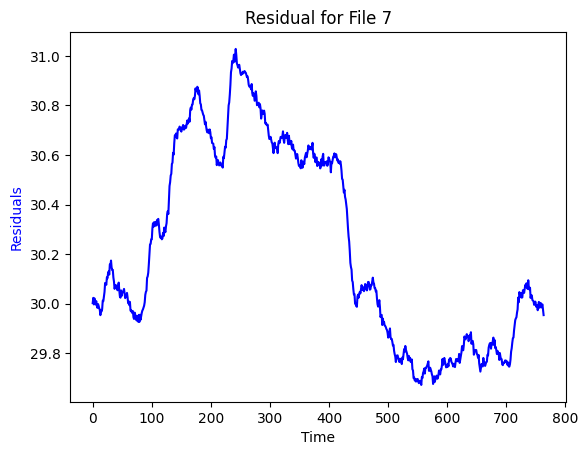

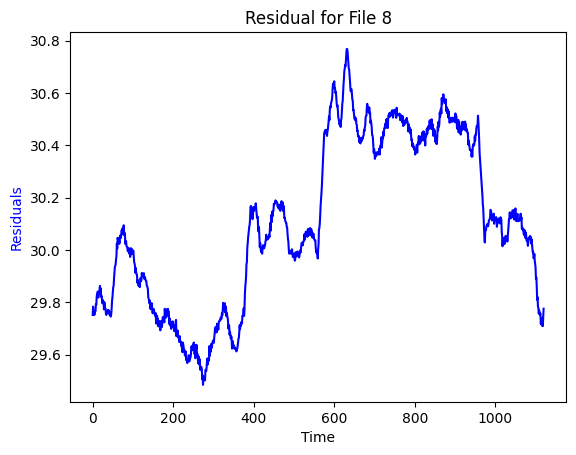

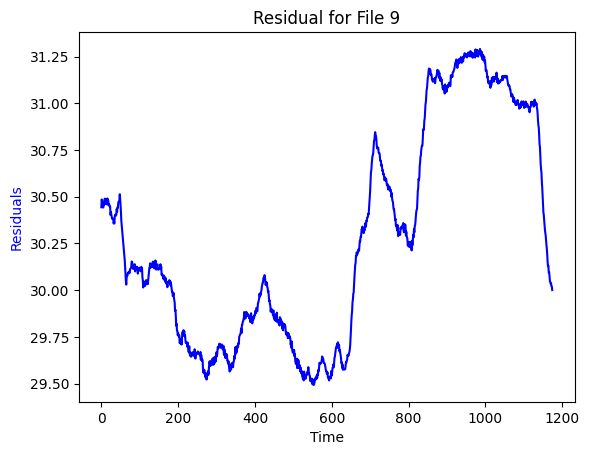

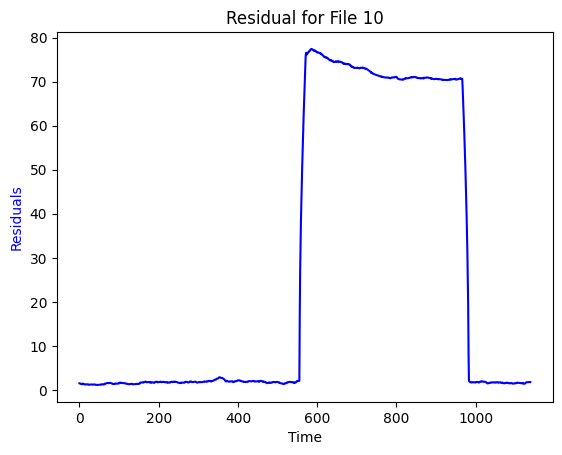

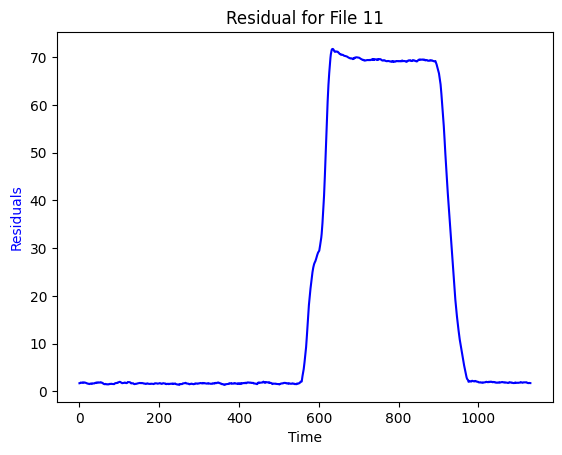

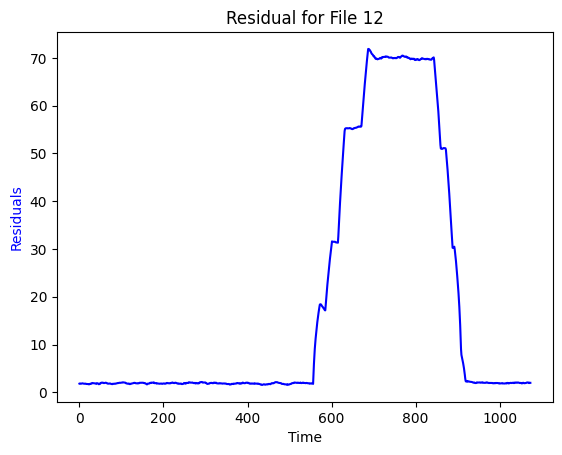

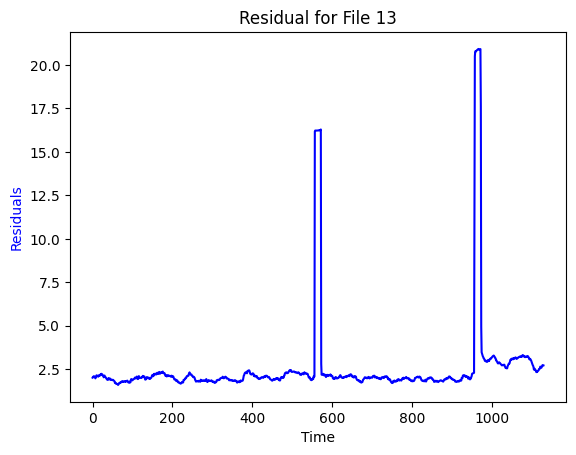

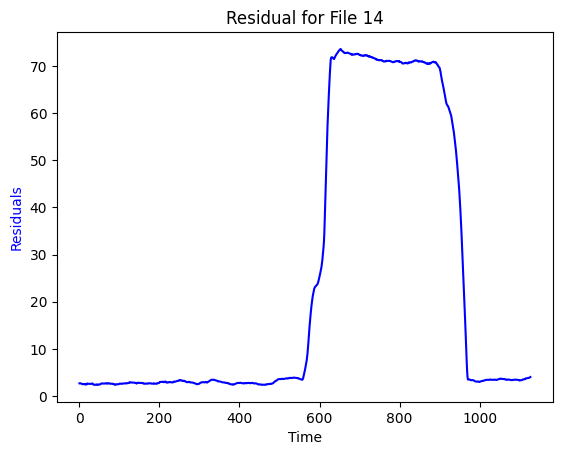

In [47]:
for i in range(len(residual_tmp_all)):
    fig, ax1 = plt.subplots()  # Create a new figure and axis for residuals

    ax1.plot(residual_tmp_all[i], 'b-')
    ax1.set_title(f'Residual for File {i+1}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residuals', color='b')

    # ax2 = ax1.twinx()  # Create a second y-axis
    # ax2.plot(tmp_anom_list[i], 'r-')
    # ax2.set_ylabel('Anomaly', color='r')
    # ax2.set_ylim(-0.1, 1.1)  # Set limits for the anomaly axis

    plt.show()